In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Train Yolov4

In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15395, done.
remote: Total 15395 (delta 0), reused 0 (delta 0), pack-reused 15395
Receiving objects: 100% (15395/15395), 14.02 MiB | 18.19 MiB/s, done.
Resolving deltas: 100% (10352/10352), done.


In [ ]:
%cd darknet
!pwd

/content/darknet


In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
# !!! In case you dont have a GPU, make sure to comment out the below 3 lines !!! #
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
  

In [ ]:
# !pip install -q torch_snippets
# !tar -xf /content/drive/MyDrive/Omdena_Resources_for_Me/object-detection-bus-trucks.tar.xz
# !rm object-detection-bus-trucks.tar.xz

!cp -r "/content/drive/MyDrive/Mastering Computer Vision/Session 2/person-bus-truck" "/content/darknet"

In [ ]:
!wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

A test on a single image

In [ ]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg

In [ ]:
%%writefile data/obj.names
person
bus
truck

Writing data/obj.names


In [ ]:
%%writefile data/obj.data
classes = 3
train = data/train.txt
valid = data/val.txt
names = data/obj.names
backup = backup/

Writing data/obj.data


In [ ]:
!mkdir -p data/obj
!cp -r person-bus-truck/images/* data/obj/
!cp -r person-bus-truck/image_paths/{train,val}.txt data/

# !cp -r object-detection-bus-trucks/images/* data/obj/
# !cp -r object-detection-bus-trucks/yolo_labels/all/{train,val}.txt data/
# !cp -r object-detection-bus-trucks/yolo_labels/all/labels/*.txt data/obj/
# !cp -r person-bus-truck/labels/validation/*.txt data/obj/


1. Equation to set max batches `(classes*2000)`
2. Filters: `(classes + 5)x3` in the 3 convolutional layer.
3.   



In [ ]:
# create a copy of existing configuration and modify it in place
!cp cfg/yolov4-tiny-custom.cfg cfg/yolov4-tiny-person-bus-trucks.cfg

# max_batches to 4000 (since the dataset is small enough)
!sed -i 's/max_batches = 500200/max_batches=6000/' cfg/yolov4-tiny-person-bus-trucks.cfg

# number of sub-batches per batch
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov4-tiny-person-bus-trucks.cfg

# number of batches after which learning rate is decayed
!sed -i 's/steps=400000,450000/steps=800,900/' cfg/yolov4-tiny-person-bus-trucks.cfg

# number of classes is 2 as opposed to 80 (which is the number of COCO classes)
!sed -i 's/classes=80/classes=3/g' cfg/yolov4-tiny-person-bus-trucks.cfg

# in the classification and regression heads, change number of output convolution filters
# from 255 -> 21 and 57 -> 33, since we have fewer classes we don't need as many filters
!sed -i 's/filters=255/filters=24/g' cfg/yolov4-tiny-person-bus-trucks.cfg
# !sed -i 's/filters=57/filters=33/g' cfg/yolov4-tiny-person-bus-trucks.cfg

In [ ]:
!wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
!cp yolov4-tiny.conv.29 build/darknet/x64/

In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-tiny-person-bus-trucks.cfg yolov4-tiny.conv.29 -dont_show -mapLastAt

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.614103), count: 35, class_loss = 5.924040, iou_loss = 46.937843, total_loss = 52.861885 
 total_bbox = 2638499, rewritten_bbox = 7.270725 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.658563), count: 9, class_loss = 1.736299, iou_loss = 0.535207, total_loss = 2.271506 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.489380), count: 7, class_loss = 1.371407, iou_loss = 12.528480, total_loss = 13.899887 
 total_bbox = 2638515, rewritten_bbox = 7.270719 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.611583), count: 9, class_loss = 2.393326, iou_loss = 0.510418, total_loss = 2.903744 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.447830), count: 31, class_loss = 4.230958, iou_loss = 85.334366, total_loss = 89.56532

In [ ]:
!cp -r /content/darknet/backup/* '/content/drive/MyDrive/Mastering Computer Vision/Session 2'

[Guides_convert_to_tflite](https://github.com/Tianxiaomo/pytorch-YOLOv4)

In [ ]:
!cp -r cfg/yolov4-tiny-person-bus-trucks.cfg '/content/drive/MyDrive/Mastering Computer Vision/Session 2'

In [ ]:
from google.colab import files
files.upload()

Saving test-bus-person.mp4 to test-bus-person.mp4


Real time on video file.

In [ ]:
!./darknet detector demo data/obj.data cfg/yolov4-tiny-person-bus-trucks.cfg backup/yolov4-tiny-person-bus-trucks_final.weights -dont_show /content/darknet/test-bus-person.mp4 -i 0 -out_filename /content/darknet/output.mp4

Streaming output truncated to the last 5000 lines.
person: 25% 

FPS:35.7 	 AVG_FPS:37.0

 cvWriteFrame 
Objects:

person: 31% 
person: 30% 

FPS:36.5 	 AVG_FPS:37.0

 cvWriteFrame 
Objects:

person: 43% 

FPS:35.5 	 AVG_FPS:37.0

 cvWriteFrame 
Objects:

person: 45% 
person: 30% 

FPS:35.3 	 AVG_FPS:37.0

 cvWriteFrame 
Objects:

truck: 40% 
bus: 35% 
person: 76% 
person: 30% 

FPS:35.6 	 AVG_FPS:32.8

 cvWriteFrame 
Objects:

truck: 40% 
bus: 36% 
person: 64% 
person: 34% 

FPS:37.0 	 AVG_FPS:32.8

 cvWriteFrame 
Objects:

truck: 43% 
bus: 43% 
person: 73% 
person: 49% 
person: 31% 

FPS:36.8 	 AVG_FPS:32.8

 cvWriteFrame 
Objects:

truck: 54% 
bus: 42% 
person: 80% 
person: 49% 
person: 47% 

FPS:35.9 	 AVG_FPS:32.8

 cvWriteFrame 
Objects:

truck: 56% 
bus: 40% 
person: 82% 
person: 46% 
person: 44% 

FPS:35.3 	 AVG_FPS:32.8

 cvWriteFrame 
Objects:

truck: 61% 
bus: 35% 
person: 73% 
person: 34% 
person: 26% 

FPS:35.1 	 AVG_FPS:32.8

 cvWriteFrame 
Objects:

truck: 65% 
bus: 34% 

In [ ]:
!pip install -q torch_snippets

     |████████████████████████████████| 41 kB 327 kB/s 
     |████████████████████████████████| 215 kB 9.2 MB/s 
     |████████████████████████████████| 57 kB 4.5 MB/s 
     |████████████████████████████████| 10.9 MB 45.6 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 5.6 MB/s 


In [ ]:
%cd /content/darknet/

/content/darknet


In [ ]:
files.upload()

Saving bus-person.jpg to bus-person.jpg


{'bus-person.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\n\x06\x08\x15\x15\x13\x17\x15\x13\x15\x17\x18\x17\x19\x1a\x1a\x1a\x1b\x19\x1a\x1a\x1f\x19\x1a\x1a\x1a\x19 \x19\x19\x19\x19\x1a\x1a\x1a +#\x1b\x1c(\x1f\x1a\x17$5$(,.222\x19#7<71;+12.\x01\x0b\x0b\x0b\x0f\x0e\x0f\x1d\x11\x11\x1d9(#(311333131131111113111111111113111111111111111111.1\xff\xc0\x00\x11\x08\x00\xb3\x01\x1a\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x01\x05\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x02\x03\x05\x06\x01\x07\x08\xff\xc4\x00?\x10\x00\x02\x01\x02\x04\x03\x05\x04\x08\x05\x04\x02\x03\x01\x00\x00\x01\x02\x11\x00\x03\x04\x12!1\x05AQ\x06\x13"aq2\x81\x91\xa1\x14#BR\xb1\xc1\xd1\xf0\x07r\x82\x92\xe1\x15Sb\xf1\xa2\xc2C\xb2\xd23\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x00\x05\x06\xff\xc4\x000\x11\x00\x02\x02\x01\x03\x02\x05\x03\x04\x00\x07\x00\x00\x00\x00\x00\x00\x01\x02\x11

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	   

2022-01-16 17:52:18.939 | INFO     | torch_snippets.paths:inner:27 - 1 files found at *_pred.jpg


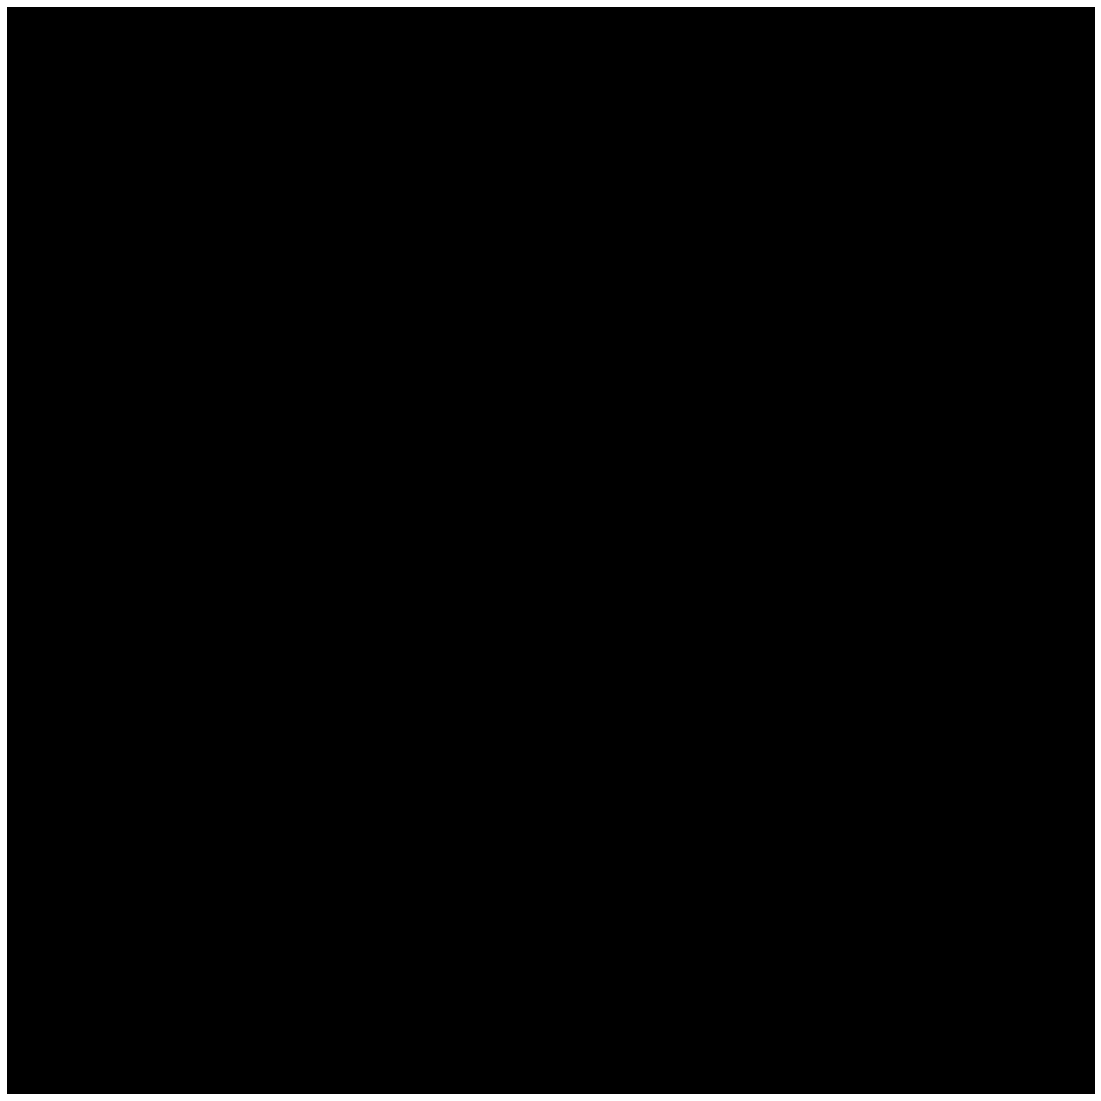

In [ ]:
from torch_snippets import Glob, stem, show, read
# upload your own images to a folder
image_paths = '/content/bus-person.jpg'
# for f in image_paths:
!./darknet detector test data/obj.data cfg/yolov4-tiny-person-bus-trucks.cfg backup/yolov4-tiny-person-bus-trucks_4000.weights {image_paths}
!mv predictions.jpg {image_paths}_pred.jpg
for i in Glob('*_pred.jpg'):
  show(read(i, 1), sz=20)

In [ ]:
files.upload()

Saving person-bus.jpg to person-bus.jpg


{'person-bus.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xe1\x00\xbeExif\x00\x00II*\x00\x08\x00\x00\x00\x02\x00\x0e\x01\x02\x00\x90\x00\x00\x00&\x00\x00\x00\x12\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00Midadult blind man, wearing casual blue clothing, holding his cellphone near his face, listening to information. He is standing at a bus station\xff\xe1\x05\xa6http://ns.adobe.com/xap/1.0/\x00<?xpacket begin="\xef\xbb\xbf" id="W5M0MpCehiHzreSzNTczkc9d"?>\n<x:xmpmeta xmlns:x="adobe:ns:meta/">\n\t<rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">\n\t\t<rdf:Description rdf:about="" xmlns:photoshop="http://ns.adobe.com/photoshop/1.0/" xmlns:Iptc4xmpCore="http://iptc.org/std/Iptc4xmpCore/1.0/xmlns/"   xmlns:GettyImagesGIFT="http://xmp.gettyimages.com/gift/1.0/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:plus="http://ns.useplus.org/ldf/xmp/1.0/"  xmlns:iptcExt="http://iptc.org/std/Iptc4xmpExt/2008-02-29/" xmlns:xmpRights="h

### Convert to ONNX file

In [ ]:
%cd /content/

/content


In [ ]:
!git clone https://github.com/Tianxiaomo/pytorch-YOLOv4.git

Cloning into 'pytorch-YOLOv4'...
remote: Enumerating objects: 1046, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 1046 (delta 31), reused 41 (delta 15), pack-reused 981
Receiving objects: 100% (1046/1046), 2.40 MiB | 15.05 MiB/s, done.
Resolving deltas: 100% (636/636), done.


In [ ]:
!pip install onnx
!pip install onnxruntime

     |████████████████████████████████| 4.9 MB 5.1 MB/s 


In [ ]:
%cd /content/pytorch-YOLOv4

/content/pytorch-YOLOv4


In [ ]:
!python demo_darknet2onnx.py /content/darknet/cfg/yolov4-tiny-person-bus-trucks.cfg /content/darknet/data/obj.names  /content/darknet/backup/yolov4-tiny-person-bus-trucks_final.weights /content/person-bus.jpg 16

Converting to onnx and running demo ...
layer     filters    size              input                output
    0 conv     32  3 x 3 / 2   416 x 416 x   3   ->   208 x 208 x  32
    1 conv     64  3 x 3 / 2   208 x 208 x  32   ->   104 x 104 x  64
    2 conv     64  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x  64
    3 route  2
    4 conv     32  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x  32
    5 conv     32  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  32
    6 route  5 4
    7 conv     64  1 x 1 / 1   104 x 104 x  64   ->   104 x 104 x  64
    8 route  2 7
    9 max          2 x 2 / 2   104 x 104 x 128   ->    52 x  52 x  64
   10 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128
   11 route  10
   12 conv     64  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x  64
   13 conv     64  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x  64
   14 route  13 12
   15 conv    128  1 x 1 / 1    52 x  52 x 128   ->    52 x  52 x 128
   16 route  10 15
   17 max          2

In [ ]:
!cp -r /content/pytorch-YOLOv4/yolov4_16_3_416_416_static.onnx '/content/drive/MyDrive/Mastering Computer Vision/Session 2/onnx-files'

In [ ]:
!cp -r /content/pytorch-YOLOv4/yolov4_1_3_416_416_static.onnx '/content/drive/MyDrive/Mastering Computer Vision/Session 2/onnx-files'

In [ ]:
!cp -r /content/pytorch-YOLOv4/predictions_onnx.jpg '/content/drive/MyDrive/Mastering Computer Vision/Session 2/onnx-files'

In [ ]:
files.upload()

{}

### Convert to tflite

In [2]:
%cd /content

/content


In [3]:
!pwd

/content


In [4]:
!git clone https://github.com/haroonshakeel/tensorflow-yolov4-tflite.git

Cloning into 'tensorflow-yolov4-tflite'...
remote: Enumerating objects: 855, done.
remote: Total 855 (delta 0), reused 0 (delta 0), pack-reused 855
Receiving objects: 100% (855/855), 200.83 MiB | 27.44 MiB/s, done.
Resolving deltas: 100% (418/418), done.


In [5]:
%cd /content/tensorflow-yolov4-tflite/
!pwd

/content/tensorflow-yolov4-tflite
/content/tensorflow-yolov4-tflite


In [9]:
!pwd

/content/tensorflow-yolov4-tflite


In [ ]:
!python save_model.py --weights '/content/drive/MyDrive/Mastering Computer Vision/Session 2/yolov4-weights/yolov4-tiny-person-bus-trucks_final.weights' --output '/content/drive/MyDrive/Mastering Computer Vision/Session 2/tflite/yolov4-tiny-416-tflite' --input_size 416 --model yolov4 --tiny

In [7]:
from google.colab import files
files.upload()

Saving test-bus-person.mp4 to test-bus-person.mp4


In [ ]:
# Run yolov4 on video
!python detectvideo.py --weights '/content/drive/MyDrive/Mastering Computer Vision/Session 2/tflite/yolov4-tiny-416' --size 416 --model yolov4 --tiny --video /content/tensorflow-yolov4-tflite/test-bus-person.mp4 --output '/content/drive/MyDrive/Mastering Computer Vision/Session 2/tflite/bus-person-out.avi'

In [6]:
# Save tf model for tflite converting
!python save_model.py --weights '/content/drive/MyDrive/Mastering Computer Vision/Session 2/tflite/yolov4-tiny-person-bus-trucks_final.weights' --output '/content/drive/MyDrive/Mastering Computer Vision/Session 2/tflite/yolov4-tiny-416-tflite' --tiny --input_size 416 --model yolov4 --framework tflite

2022-01-17 03:12:13.910969: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 417, 417, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 208, 208, 32  864         ['zero_padding2d[0][0]']         
                               

In [ ]:
# yolov4
!python convert_tflite.py --weights '/content/drive/MyDrive/Mastering Computer Vision/Session 2/tflite/yolov4-416' --output '/content/drive/MyDrive/Mastering Computer Vision/Session 2/tflite/yolov4-416.tflite'

In [9]:
# yolov4 quantize int8
!python convert_tflite.py --weights '/content/drive/MyDrive/Mastering Computer Vision/Session 2/tflite/yolov4-tiny-416-tflite' --output '/content/drive/MyDrive/Mastering Computer Vision/Session 2/onnx-tflite-inference/yolov4-tiny-416-int8.tflite' --quantize_mode int8

2022-01-17 03:16:02.385174: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-17 03:16:05.832723: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-01-17 03:16:05.832786: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-01-17 03:16:05.832798: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2022-01-17 03:16:07.263147: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1891] TFLite interpreter needs to link Flex delegate in order to run the model since it contains the following Select TFop(s):
Flex ops: FlexFusedBatchNormV3
Details:
	tf.FusedBatchNormV3(tensor<?x104x104x32xf32>, tensor<32xf32>, tensor<32xf32>, tensor<32xf32>, tensor<32xf32>) -> (tensor<?x104x104x32xf32>, tensor<32xf32>, tensor<32xf32>, tensor<32xf32>, tensor

In [ ]:

# yolov4 quantize float16
!python convert_tflite.py --weights '/content/drive/MyDrive/Mastering Computer Vision/Session 2/tflite/yolov4-416' --output '/content/drive/MyDrive/Mastering Computer Vision/Session 2/tflite/yolov4-416-fp16.tflite' --quantize_mode float16



In [11]:
# Run demo tflite on videos
!python detect_video.py --weights '/content/drive/MyDrive/Mastering Computer Vision/Session 2/onnx-tflite-inference/yolov4-tiny-416-int8.tflite' --size 416 --tiny --model yolov4 --video '/content/drive/MyDrive/Mastering Computer Vision/Session 2/test-bus-person.mp4' --output '/content/drive/MyDrive/Mastering Computer Vision/Session 2/tflite/video_output.avi' --framework tflite

2022-01-17 03:20:32.765736: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Video from:  /content/drive/MyDrive/Mastering Computer Vision/Session 2/test-bus-person.mp4
INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 19 nodes delegated out of 286 nodes with 18 partitions.

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 416, 416,   3], dtype=int32), 'shape_signature': array([ -1, 416, 416,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 447, 'shape': array([1, 1, 4], dtype=int32), 'shape_signature': array([ 1, -1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantiza